# L4-A - Building your own Quantizer: Custom Build an 8-Bit Quantizer

In this lesson, you will learn how to compress any model in 8-bit precision.

我们将利用前面构建的工具创建自己的量化器，以8-bit精度量化任意模型。这个量化器是模态无关的，也就是说你可以将其应用于视觉、音频、文本甚至多模态模型。  

我们用per channel线性量化方案，制作我们自己的量化器，以8-bit精度量化任意模型。因此，我们将把该项目拆分成多个子任务。  
首先，我们将创建一个W8A16LinearLayer类。W8代表8-bit权重，A16代表16-bit激活。我们将使用这个类存储8-bit权重和scale。  
然后，我们将用这个新类替换torch.nn.Linear。  
然后，我们将构建一个量化器，对模型进行端到端的量化。  
我们将在许多场景下测试我们的量化器，研究8-bit量化对不同模型的影响。  

现在，让我们从第一个子任务开始，构建W8A16LinearLayer类。  
对于这个任务，我们将它再分成多个子任务。  
首先，我们构建一个名为w8_a16_forward的前向方法，该方法将以8-bit的权重，16-bit的input，scale和可选的bias作为输入。  

## Step 1: class `W8A16LinearLayer`

- Build the target class, `W8A16LinearLayer()`, that will be responsible for quantizing your model.

### 1.1 - `w8_a16_forward` Function

-
```Python
W8A16LinearLayer
                    # 8-bit  # 16-bit         # optional
* w8_a16_forward -> weights, input,   scales, bias=None
                    
```
- Cast the 8-bit `weights` to the same data type as the `input`, "casted weights",
- keeping the "casted weights" in the same range as before, [-128, 127]
- Next, $$(({inputs} \cdot \text{``casted weights''}) * {scale}) + {bias}$$ 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
random_int8 = torch.randint(-128, 127, (32, 16)).to(torch.int8)  # 随机INT8 tensor代表量化权重，指定数值范围是[-128, 127], 形状是(32, 16)
random_hs = torch.randn((1, 16), dtype=torch.bfloat16)  # 定义input, 或hidden state，数据类型是bfloat16
scales = torch.randn((1, 32), dtype=torch.bfloat16)  # 因为权重形状是(32, 16)，每一行对应一个scale，所以scales形状为（1, 32），其数据类型是bfloat16
bias = torch.randn((1, 32), dtype=torch.bfloat16)  # bias形状也为(1, 32)，数据类型bloat16

**Note:** Since the values are random, what you see in the video might be different than what you will get.

In [3]:
# random_hs是input，random_int8是量化权重（线性变换前要先转换成与random_hs相同的数据类型）
F.linear(random_hs, random_int8.to(random_hs.dtype))

tensor([[ -63.2500,  213.0000, -168.0000,  -67.5000, -296.0000, -320.0000,
         -656.0000,  -51.2500,  -41.5000,  270.0000, -120.5000,  -23.0000,
           31.1250, -239.0000,    9.0000,  412.0000, -532.0000,  556.0000,
          212.0000, -462.0000, -608.0000,  420.0000,  548.0000,  328.0000,
           21.6250, -648.0000,  173.0000, -408.0000,  604.0000,  224.0000,
          110.0000,  400.0000]], dtype=torch.bfloat16)

In [4]:
# 线性变换 * scales
F.linear(random_hs, random_int8.to(random_hs.dtype)) * scales

tensor([[ -23.2500, -286.0000,  544.0000,  102.5000,  264.0000,  151.0000,
          804.0000,   13.3125,   19.5000, -384.0000,  -87.5000,    4.9062,
          -11.3125,  -19.7500,    3.0312, -278.0000, -884.0000,  616.0000,
         -173.0000, -169.0000,  600.0000,   19.1250, -151.0000,   60.0000,
          -21.2500,  209.0000,  -43.0000,  504.0000,  580.0000,  215.0000,
          -12.3750, -106.0000]], dtype=torch.bfloat16)

In [5]:
# (线性变换 * scales) + bias
(F.linear(random_hs, random_int8.to(random_hs.dtype)) * scales) + bias

tensor([[ -24.0000, -284.0000,  544.0000,  103.0000,  266.0000,  151.0000,
          804.0000,   11.5000,   18.8750, -382.0000,  -88.5000,    6.6562,
          -11.5000,  -20.5000,    1.9609, -278.0000, -884.0000,  616.0000,
         -174.0000, -169.0000,  600.0000,   21.3750, -151.0000,   59.7500,
          -20.7500,  210.0000,  -43.5000,  504.0000,  580.0000,  215.0000,
          -12.8125, -105.5000]], dtype=torch.bfloat16)

- Implement all this as a function, `w8_a16_forward`

In [6]:
# 封装上面的工作，定义w8_a16_forward函数。
# weight是量化权重，input是输入，做线性变换前要将量化权重转换为input相同数据类型（这里直接进行类型转换，有个问题是，需要做反量化吗？）。
def w8_a16_forward(weight, input, scales, bias=None):
    
    # 将量化权重转换为与input相同的数据类型（一个疑问，需要做反量化吗？）
    casted_weights = weight.to(input.dtype)

    # 进行线性变量，结果再乘以scales
    output = F.linear(input, casted_weights) * scales
    
    # bias是可选的，如果指定了bias，output加上bias。
    if bias is not None:
        output = output + bias
      
    return output

In [7]:
print("With bias:\n\n", 
      w8_a16_forward(random_int8, random_hs, scales, bias))

print("\nWithout bias:\n\n", 
      w8_a16_forward(random_int8, random_hs, scales))

With bias:

 tensor([[ -24.0000, -284.0000,  544.0000,  103.0000,  266.0000,  151.0000,
          804.0000,   11.5000,   18.8750, -382.0000,  -88.5000,    6.6562,
          -11.5000,  -20.5000,    1.9609, -278.0000, -884.0000,  616.0000,
         -174.0000, -169.0000,  600.0000,   21.3750, -151.0000,   59.7500,
          -20.7500,  210.0000,  -43.5000,  504.0000,  580.0000,  215.0000,
          -12.8125, -105.5000]], dtype=torch.bfloat16)

Without bias:

 tensor([[ -23.2500, -286.0000,  544.0000,  102.5000,  264.0000,  151.0000,
          804.0000,   13.3125,   19.5000, -384.0000,  -87.5000,    4.9062,
          -11.3125,  -19.7500,    3.0312, -278.0000, -884.0000,  616.0000,
         -173.0000, -169.0000,  600.0000,   19.1250, -151.0000,   60.0000,
          -21.2500,  209.0000,  -43.0000,  504.0000,  580.0000,  215.0000,
          -12.3750, -106.0000]], dtype=torch.bfloat16)


### 1.2 - `init` Function of class `W8A16LinearLayer`

- This is how the `init` is of [PyTorch Linear layer](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear):
```Python
def __init__(self, in_features, out_features, bias=True,
             device=None, dtype=None)

```

下一个子任务：实现W8A16LinearLayer类的init方法。

PyTorch线性层init方法声明如下：  
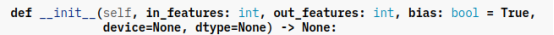  
我们要实现的init方法必须与PyTorch线性层的init方法相匹配，所以它必须包含输入特征，输出特征，偏置项，数据类型。这里数据类型是bias的数据类型。

我们将在init方法中定义我们的INT8权重和scale。

In [8]:
### running this will result in an error
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, 
                 bias=True, dtype=torch.float32):
        super().__init__()
        
        self.int8_weights = nn.Parameter(torch.Tensor([0, 1]
                                     ).to(dtype=torch.int8))

try:
    
    W8A16LinearLayer(1, 1)
    
except Exception as error:
    print("\033[91m", type(error).__name__, ": ", error, "\033[0m")

 RuntimeError :  Only Tensors of floating point and complex dtype can require gradients 


上面这种定义int8_weights的方法的问题在于，当你创建一个nn.Parameter时，PyTorch期望能在其上计算梯度，但是PyTorch不能在INT8张量上计算梯度，因此会报错，指出只有浮点数和复数才能计算梯度。  

所以，存储int8_weights的正确方法，不是将它保存为nn.Parameter，而是调用register_buffer方法。这样，我们不是存储参数，而是存储一个缓冲区。这意味着我们不需要在该tensor上计算梯度，并且你可以用任何你想要的数据类型来初始化它。  

因为我们只期望进行推理，而不关心训练，所以我们不需要计算梯度，所以使用register_buffer方法就足够了。  
初始化完int8_weights后，同样通过register_buffer方法初始化scales和bias。

In [9]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, 
                 bias=True, dtype=torch.float32):
        super().__init__()        
        
        self.register_buffer(
            "int8_weights",
            torch.randint(
                -128, 127, (out_features, in_features), dtype=torch.int8
            )
        )
        
        self.register_buffer("scales", 
                             torch.randn((out_features), dtype=dtype))
        
        if bias:
            self.register_buffer("bias", 
                                 torch.randn((1, out_features), 
                                             dtype=dtype))
        
        else:
            self.bias = None

- Test your implementation.

In [10]:
# 初始化自定义线性层对象，in_features是16，out_features是32
dummy_instance = W8A16LinearLayer(16, 32)

In [11]:
# 查看量化权重的形状
print(dummy_instance.int8_weights.shape)

# 查看scales的形状
print(dummy_instance.scales.shape)

torch.Size([32, 16])
torch.Size([32])


### 1.3 - `forward` Function of class `W8A16LinearLayer`

- Use the `w8_a16_forward` defined earlier (Step 1.1) to define the `forward` function.

In [12]:
# 结合前面的工作，定义W8A16LinearLayer类，包括__init__和forward方法
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, 
                 bias=True, dtype=torch.float32):
        super().__init__()
        
        
        self.register_buffer(
            "int8_weights",
            torch.randint(
                -128, 127, (out_features, in_features), dtype=torch.int8
            )
        )
        
        self.register_buffer("scales", 
                             torch.randn((out_features), dtype=dtype))
        
        if bias:
            self.register_buffer("bias", 
                                 torch.randn((1, out_features), 
                                             dtype=dtype))
        
        else:
            self.bias = None

    def forward(self, input):
        return w8_a16_forward(self.int8_weights, 
                              input, self.scales, self.bias)

In [13]:
# 初始化自定义线性层对象
module = W8A16LinearLayer(16, 32)

# 随机生成input
dummy_hidden_states = torch.randn(1, 6, 16)

# 注意input类型是float32，所以后面经过线性变换，输出的数据类型也是float32
dummy_hidden_states.dtype

torch.float32

In [14]:
# dummy_hidden_states通过自定义线性层做线性变换
module(dummy_hidden_states).shape

torch.Size([1, 6, 32])

In [15]:
# 因为input的数据类型是float32，尽管量化权重是INT8的，但是输出的数据类型也是float32
module(dummy_hidden_states).dtype

torch.float32

### 1.4 - `quantize` Function of class `W8A16LinearLayer`

- `quantize` function will dynamically quantize half-precision weights into `torch.int8`

现在，我们有了一个forward函数工作正常的线性层类，具有所有必要属性，我们还需要创建一个量化方法，以执行之前介绍的线性量化算法，用于量化权重。

因为现在，一切都是随机的，我们创建的self.int8_weights是一个随机生成的INT8 tensor，如果你用这个线性层替换模型的线性层，你很可能会得到一些无意义的输出。  
正确的做法应该是定义一个量化函数，将原来线性层的权重通过该量化函数进行量化，代替默认生成的随机self.int8_weights，然后才能用forward推理得到正确结果。  

一旦我们定义了量化方法，工作流程将如下：  
你会有你的基本模型，假设是半精度的。  
将循环遍历所有线性层类。  
用我们的新线性层类替换它们。  
然后执行量化。通过传递旧权重将其量化为INT8数据类型，替换self.int8_weights。  
然后就可以调用forward方法得到正确推理结果。  
所以让我们重新定义我们的W8A16LinearLayer类：

In [16]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, 
                 bias=True, dtype=torch.float32):
        super().__init__()
        
        
        self.register_buffer(
            "int8_weights",
            torch.randint(
                -128, 127, (out_features, in_features), dtype=torch.int8
            )
        )
        
        self.register_buffer("scales", 
                             torch.randn((out_features), dtype=dtype))
        
        if bias:
            self.register_buffer("bias", 
                                 torch.randn((1, out_features), 
                                             dtype=dtype))
        
        else:
            self.bias = None

    def quantize(self, weights):
        # clone原始权重到w_fp32，将数据类型转换为FP32以保持稳定性。注意这个w_fp32仅仅在计算scale时用到，量化时还是用的原始权重。
        w_fp32 = weights.clone().to(torch.float32)

        # 线性对称量化公式计算scales
        # w_fp32.abs()计算了张量w_fp32中每个元素的绝对值。
        # max(dim=-1).values 计算了沿着最后一个维度的最大值，并获取最大值本身（而不是索引）。
        # 注意：这里使用w_fp32最后一个维度的最大值来计算scale，说明使用的是per channel量化。
        scales = w_fp32.abs().max(dim=-1).values / 127

        # 将scale设置为与原始权重相同的数据类型。
        scales = scales.to(weights.dtype)

        # 根据线性对称量化公式对原始权重进行per channel量化。
        int8_weights = torch.round(weights
                        /scales.unsqueeze(1)).to(torch.int8)

        # 将量化后的权重和scale保存到self.int8_weights和self.scales中。
        self.int8_weights = int8_weights
        self.scales = scales
    
    def forward(self, input):
        return w8_a16_forward(self.int8_weights, 
                              input, self.scales, self.bias)      

In [17]:
# 初始化自定义线性层对象module，in_features为4, out_features为8
module = W8A16LinearLayer(4, 8)

In [18]:
# 初始时量化权重形状为(8, 4)
print("Weights before:\n" , module.int8_weights)

Weights before:
 tensor([[ -60,   96,   38,  -33],
        [-111,   10, -125,  -54],
        [  44,   98,  112,  -83],
        [  12,  -95,   31, -120],
        [ -58,  -59,  -17,  -43],
        [  39,   38,  116,  -91],
        [ -13,   17,   57,   92],
        [-109,  -21,   34,   92]], dtype=torch.int8)


In [19]:
# 定义一个(4, 8)的随机矩阵，代表一个线性层的权重
random_matrix = torch.randn((4, 8), dtype=torch.bfloat16)
random_matrix

tensor([[ 0.3008,  0.3457, -1.6016,  1.3828,  1.6797,  0.1885,  1.8516, -0.1162],
        [-0.5430, -0.8594,  1.0156, -0.6484,  0.2070, -0.8242, -0.2949,  1.6562],
        [-0.1035, -0.6562, -0.9570, -0.5391, -0.9688, -0.0762,  1.2578,  0.0239],
        [-1.8438, -0.9805, -1.1094,  0.9336,  0.1387, -0.8672,  0.0933,  1.0000]],
       dtype=torch.bfloat16)

In [20]:
# 使用自定义线性层对象module的quantize方法对random_matrix进行量化
module.quantize(random_matrix)

In [21]:
# 量化后，自定义线性层对象module的int8_weights被替换
print("Weights After:\n" , module.int8_weights)

Weights After:
 tensor([[  21,   24, -110,   95,  115,   13,  127,   -8],
        [ -42,  -66,   78,  -50,   16,  -63,  -23,  127],
        [ -10,  -66,  -97,  -54,  -98,   -8,  127,    2],
        [-127,  -68,  -76,   64,   10,  -60,    6,   69]], dtype=torch.int8)


In [22]:
module.scales

tensor([0.0146, 0.0131, 0.0099, 0.0145], dtype=torch.bfloat16)

In [23]:
module.scales.shape

torch.Size([4])

In [24]:
module.int8_weights.shape

torch.Size([4, 8])

In [25]:
# 执行反量化
### dequantized weights
module.int8_weights * module.scales.unsqueeze(1)

tensor([[ 0.3066,  0.3496, -1.6016,  1.3828,  1.6797,  0.1895,  1.8516, -0.1167],
        [-0.5469, -0.8633,  1.0156, -0.6523,  0.2090, -0.8242, -0.3008,  1.6562],
        [-0.0986, -0.6523, -0.9609, -0.5352, -0.9688, -0.0791,  1.2578,  0.0198],
        [-1.8438, -0.9883, -1.1016,  0.9297,  0.1455, -0.8711,  0.0869,  1.0000]],
       dtype=torch.bfloat16)

In [26]:
### original weights
random_matrix

tensor([[ 0.3008,  0.3457, -1.6016,  1.3828,  1.6797,  0.1885,  1.8516, -0.1162],
        [-0.5430, -0.8594,  1.0156, -0.6484,  0.2070, -0.8242, -0.2949,  1.6562],
        [-0.1035, -0.6562, -0.9570, -0.5391, -0.9688, -0.0762,  1.2578,  0.0239],
        [-1.8438, -0.9805, -1.1094,  0.9336,  0.1387, -0.8672,  0.0933,  1.0000]],
       dtype=torch.bfloat16)

In [27]:
# 计算量化误差，可以看到，量化误差很小，这说明W8A16LinearLayer类的quantize方法工作正常
(random_matrix - module.int8_weights 
 * module.scales.unsqueeze(1)).abs().mean()

tensor(0.0028, dtype=torch.bfloat16)